# Projet 4 : Anticiper les besoins en consommation électrique de bâtiments
*Pierre-Eloi Ragetly*

Ce projet fait parti du parcours *DataScientist* d'OpenClassrooms.

L'objectif principal est de trouver un modèle permettant de prédire **les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l'habitation.**

Pour cela nous disposons des données de la ville de Seattle pour les années 2015 et 2016. Ces données sont à récupérer sur le site kaggle.

# Partie II : Feature Engineering

Ce notebook a pour but de présenter le travail effectué sur l'ingénierie de variables. C'est à dire toutes les transformations effectuées sur les variables afin d'améliorer les performances du modèle. Les données nettoyées (cf Partie I), seront utilisées.

De plus, Un premier tri parmi les variables sera effectué. Celles qui ne seront clairement pas pertinentes pour l'exercice de modélisation, par exemple l'adresse des bâtiments, seront écartées.

In [1]:
# Import des librairies usuelles
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns

In [2]:
# Change some default parameters of matplotlib using seaborn
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'axes.titleweight': 'bold'})
sns.set(style='ticks')
current_palette = sns.color_palette('RdBu')
sns.set_palette(current_palette)

In [3]:
data_2015 = pd.read_csv('data/data_2015.csv')
data_2016 = pd.read_csv('data/data_2016.csv')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sélection-de-variables" data-toc-modified-id="Sélection-de-variables-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sélection de variables</a></span></li><li><span><a href="#Analyse-des-variables-cibles" data-toc-modified-id="Analyse-des-variables-cibles-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analyse des variables cibles</a></span></li></ul></div>

In [4]:
data_2015.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'DefaultData', 'Comments', 'ComplianceStatus', 'Latitude', 'Longitude',
       'Address', 'City', 'State', 'ZipCode'],
      dtyp

## Sélection de variables

Nombre de variables ne sont pas pertinentes pour modéliser la consommation en énergie ou l'émission de CO2. Elles viennent donc polluer le jeu de données et risque d'abaisser l'efficacité de notre modèle, il faut donc les écarter avant de procéder à l'entrainement des modèles.

Parmi elles nous allons trouver des variables renvoyant toutes la même donnée :
- DataYear
- ComplianceStatus
- City
- State

Nous avons aussi des variables qui pourraient s'apparenter à un identifiant. Ayant déja choisi comme identifiant *OSEBuildingID* (cf. Partie I), elles sont donc redondantes et peuvent être écartées sans risquer de perdre de l'information :
- PropertyName
- TaxParcelIdentificationNumber
- Address

D'autres n'auront clairement aucun lien avec les attributs que nous cherchons à modéliser :
- YearsENERGYSTARCertified
- DefaultData

Une variable contient très peu de valeurs renseignée, cinq en tout. De plus, il s'agit de texte, et est donc difficilement utilisable par les algorithmes d'apprentissage automatique classiques :
- Comments

Pour finir, certaines sont redondantes :
- BuildingType (redondante avec PrimaryPropertyType, cf. Partie I)
- CouncilDistrictCode (redondante avec Neighborhood)
- ZipCode (redondante avec Neighborhood)

In [5]:
data_2015['CouncilDistrictCode'].value_counts()

7    375
2    289
3    171
4    117
5    107
1     99
6     94
Name: CouncilDistrictCode, dtype: int64

In [6]:
data_2015['Neighborhood'].value_counts()

DOWNTOWN                 253
GREATER DUWAMISH         248
EAST                     111
MAGNOLIA / QUEEN ANNE    105
LAKE UNION               103
NORTHEAST                 92
NORTHWEST                 76
BALLARD                   54
NORTH                     53
CENTRAL                   44
DELRIDGE                  39
SOUTHEAST                 39
SOUTHWEST                 35
Name: Neighborhood, dtype: int64

In [7]:
data_2015['DefaultData'].value_counts()

No     1105
Yes     147
Name: DefaultData, dtype: int64

In [8]:
data_2015['Comments'].dropna()

334    Part of McKinstry's campus, property operates ...
335    One of two office buildings on McKinstry's cam...
437    Part of McKinstry’s campus, this remodeled war...
711    Under construction starting 6/2015 (old buildi...
991    Part of McKinstry's campus, property includes ...
Name: Comments, dtype: object

In [9]:
data_2015['ComplianceStatus'].value_counts()

Compliant    1252
Name: ComplianceStatus, dtype: int64

In [10]:
data_2015['City'].value_counts()

SEATTLE    1252
Name: City, dtype: int64

In [11]:
data_2015['State'].value_counts()

WA    1252
Name: State, dtype: int64

In [12]:
data_2015['ZipCode'].value_counts()

98134    145
98104    118
98101    110
98109    104
98108     83
98122     75
98105     64
98121     56
98103     52
98125     51
98119     45
98115     41
98133     40
98118     39
98107     38
98144     36
98106     25
98102     23
98116     21
98112     21
98117     20
98126     20
98199     13
98178      4
98136      4
98177      2
98146      1
98155      1
Name: ZipCode, dtype: int64

In [13]:
cols_to_del = ['DataYear',
               'ComplianceStatus',
               'City',
               'State',
               'PropertyName',
               'TaxParcelIdentificationNumber',
               'Address',
               'YearsENERGYSTARCertified',
               'DefaultData',
               'Comments',
               'BuildingType',
               'CouncilDistrictCode',
               'ZipCode']

data_2015.set_index('OSEBuildingID', inplace=True)
data_2015.drop(columns=cols_to_del, inplace=True)

In [14]:
data_2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1252 entries, 1 to 50008
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PrimaryPropertyType              1252 non-null   object 
 1   Neighborhood                     1252 non-null   object 
 2   YearBuilt                        1252 non-null   int64  
 3   NumberofBuildings                1252 non-null   int64  
 4   NumberofFloors                   1245 non-null   float64
 5   PropertyGFATotal                 1252 non-null   int64  
 6   PropertyGFAParking               1252 non-null   int64  
 7   PropertyGFABuilding(s)           1252 non-null   int64  
 8   ListOfAllPropertyUseTypes        1208 non-null   object 
 9   LargestPropertyUseType           1206 non-null   object 
 10  LargestPropertyUseTypeGFA        1206 non-null   float64
 11  SecondLargestPropertyUseType     616 non-null    object 
 12  SecondLargestProper

## Analyse des variables cibles

La première grandeur que nous cherchons à prédire est l'émission de CO2. Cette grandeur est renseignée dans nos jeux de données par la variable **TotalGHGEmissions**.

La deuxième est la consommation totale d'énergie, elle est renseignée par la variable **SiteEnergyUse(kBtu)**.

Commençons par voir la distribution de ces variables à l'aide d'un histogramme.

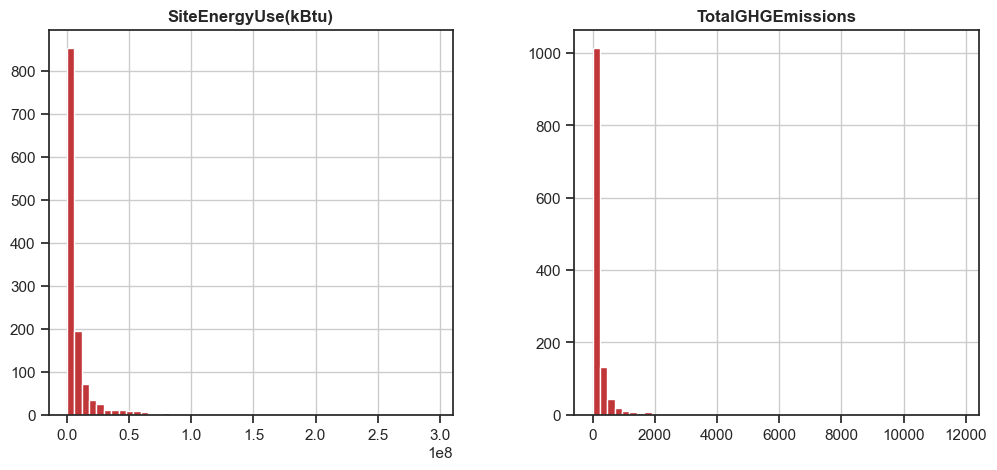

In [15]:
data_2015[['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']].hist(bins=50, figsize=(12, 5))
plt.show()

Nous constatons que la distribution est fortement asymétrique pour les deux variables. La forme s'apparente plus à une distribution log normale que normale. Or, en général les algorithmes de Machine Learning (ML) sont plus performants quand les données suivent une distribution normale. Appliquons le log sur les deux variables, et regardons si on obtient une distribution un peu plus proche d'une cloche, forme typique de la distribution normale.

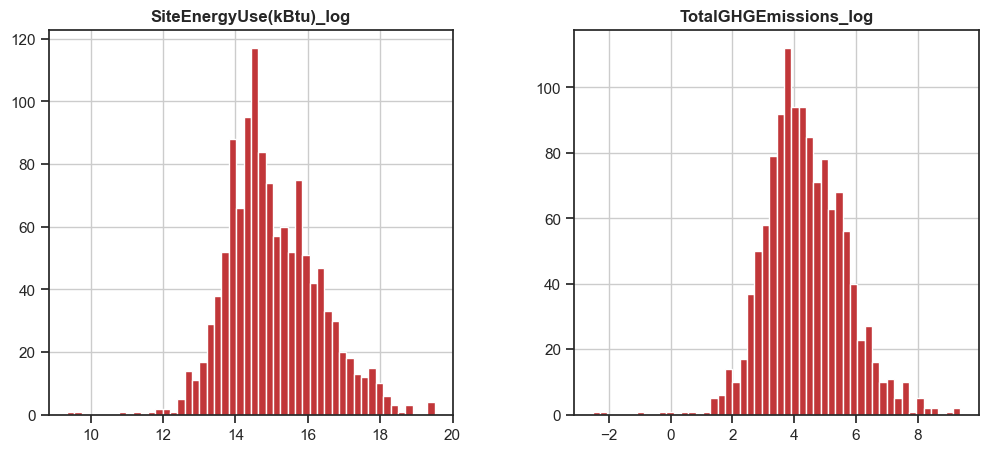

In [17]:
df = data_2015.copy()
df['SiteEnergyUse(kBtu)_log'] = np.log(df['SiteEnergyUse(kBtu)'])
df['TotalGHGEmissions_log'] = np.log(df['TotalGHGEmissions'])
df[['TotalGHGEmissions_log', 'SiteEnergyUse(kBtu)_log']].hist(bins=50, figsize=(12, 5))
plt.show()

C'est nettement mieux. **Nous entrainerons donc nos modèles sur le logarithme de ces variables. Puis nous appliquerons l'exponentielle sur les prédictions pour obtenir les bonnes valeurs.**

In [18]:
data_2015['SiteEnergyUse(kBtu)_log'] = np.log(data_2015['SiteEnergyUse(kBtu)'])
data_2015['TotalGHGEmissions_log'] = np.log(data_2015['TotalGHGEmissions'])